In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### dataset information

In [4]:
from datetime import datetime

dataset = "cifar10"
dims = (32, 32, 3)
num_classes = 10
labels_per_class = 4 # full
batch_size = 128
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_baseline_augmented'
)
print(datestring)

cifar10_4____2020_08_11_19_25_58_939055_baseline_augmented


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build network

In [8]:
from tensorflow.keras import datasets, layers, models
from tensorflow_addons.layers import WeightNormalization

def conv_block(filts, name, kernel_size = (3, 3), padding = "same", **kwargs):
    return WeightNormalization(
        layers.Conv2D(
            filts, kernel_size, activation=None, padding=padding, **kwargs
        ),
        name="conv"+name,
    )
#CNN13
#See: 
#https://github.com/vikasverma1077/ICT/blob/master/networks/lenet.py
#https://github.com/brain-research/realistic-ssl-evaluation

In [9]:

lr_alpha = 0.1
dropout_rate = 0.5
num_classes = 10
input_shape = (32, 32, 3)
model = models.Sequential()
model.add(tf.keras.Input(shape=input_shape))
### conv1a
name = '1a'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1b
name = '1b'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1c
name = '1c'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp1"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop1"))

### conv2a
name = '2a'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha))

### conv2b
name = '2b'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv2c
name = '2c'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp2"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop2"))

### conv3a
name = '3a'
model.add(conv_block(name = name, filts = 512, kernel_size = (3,3), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3b
name = '3b'
model.add(conv_block(name = name, filts = 256, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3c
name = '3c'
model.add(conv_block(name = name, filts = 128, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.AveragePooling2D(pool_size=(6, 6), strides=2, padding='valid'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation=None, name='z'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc1'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc2'))
model.add(WeightNormalization(layers.Dense(num_classes, activation=None)))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1a (WeightNormalization) (None, 32, 32, 128)       7297      
_________________________________________________________________
bn1a (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1a (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1b (WeightNormalization) (None, 32, 32, 128)       295297    
_________________________________________________________________
bn1b (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1b (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1c (WeightNormalization) (None, 32, 32, 128)       2

### Augmentation

In [11]:
import tensorflow_addons as tfa
def augment(image, label):
    image = tf.squeeze(image) # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, dims[0] + 6, dims[1] + 6) # crop 6 pixels
    image = tf.image.random_crop(image, size=dims)
    image = tf.image.random_brightness(image, max_delta=0.15)  # Random brightness
    image= tf.image.random_contrast(image, lower=0.6, upper=1.4)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, 0.05, seed=None)
    #image = tf.image.random_jpeg_quality(image, 10, 100, seed=None)
    image = tfa.image.rotate(image, tf.squeeze(tf.random.uniform(shape = (1,1), minval=-.2, maxval=.2)), interpolation='BILINEAR')
    image = tfa.image.random_cutout(tf.expand_dims(image, 0), (8,8), constant_values=0.5)[0]
    image = tf.clip_by_value(image, 0, 1)
    return image, label

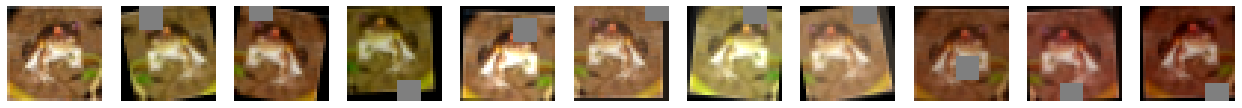

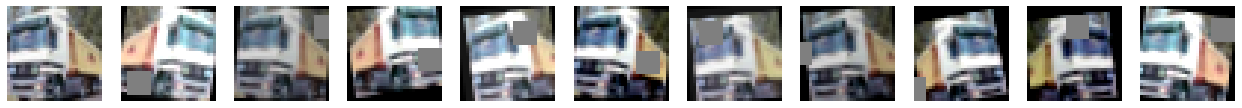

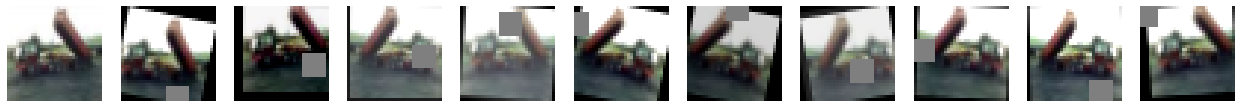

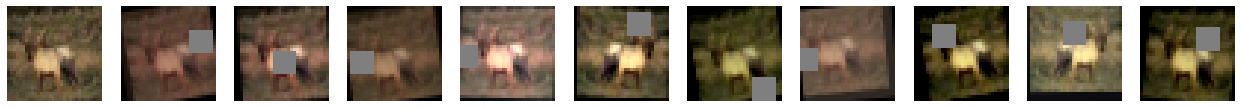

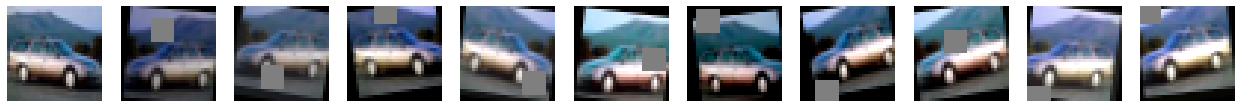

In [12]:
nex = 10
for i in range(5):
    fig, axs = plt.subplots(ncols=nex +1, figsize=((nex+1)*2, 2))
    axs[0].imshow(X_train[i])
    axs[0].axis('off')
    for ax in axs.flatten()[1:]:
        ax.imshow(augment(X_train[i], Y_train[i])[0])
        ax.axis('off')

### train

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

In [14]:
opt = tf.keras.optimizers.Adam(1e-3)
opt = tfa.optimizers.MovingAverage(opt)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)
model.compile(opt, loss = loss, metrics=['accuracy'])

In [15]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [16]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

In [17]:
from livelossplot import PlotLossesKerasTF
# plot losses callback
plotlosses = PlotLossesKerasTF()

In [18]:
train_ds = (
     tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled_one_hot))
    .repeat()
    .shuffle(len(X_labeled))
    .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
) 

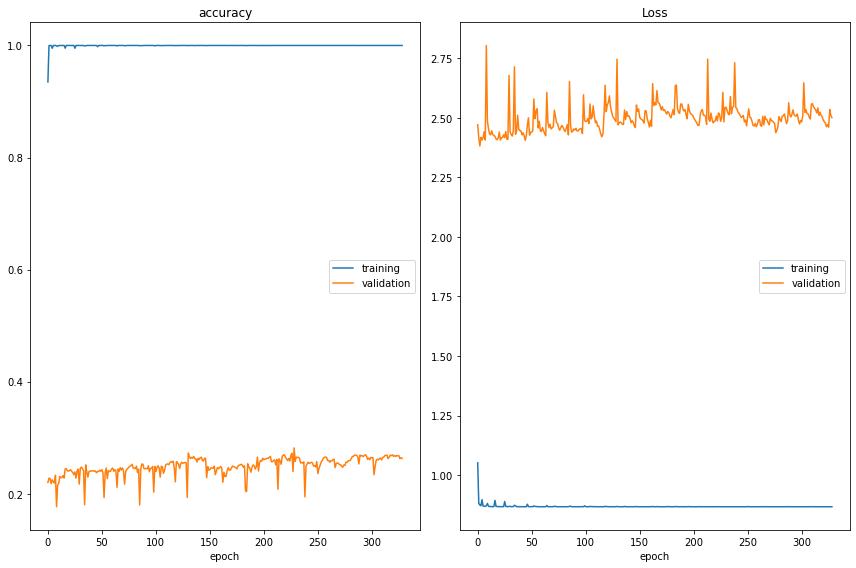

accuracy
	training         	 (min:    0.935, max:    1.000, cur:    1.000)
	validation       	 (min:    0.177, max:    0.282, cur:    0.263)
Loss
	training         	 (min:    0.867, max:    1.051, cur:    0.867)
	validation       	 (min:    2.382, max:    2.804, cur:    2.501)
312/312 [==============================] - 20s 65ms/step - loss: 0.8669 - accuracy: 1.0000 - val_loss: 2.5009 - val_accuracy: 0.2631


In [19]:
steps_per_epoch = int(len(X_train)/ batch_size)
history = model.fit(
    train_ds,
    epochs=500,
    validation_data=(X_valid, Y_valid_one_hot),
    callbacks = [early_stopping, plotlosses],
    steps_per_epoch = steps_per_epoch,
)

### evaluate

In [20]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

313/313 [==============================] - 3s 9ms/step - loss: 2.4894 - accuracy: 0.2814


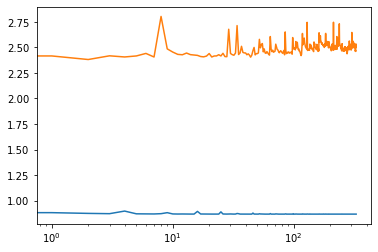

In [21]:
plt.semilogx(history.history['loss'])
plt.semilogx(history.history['val_loss'])

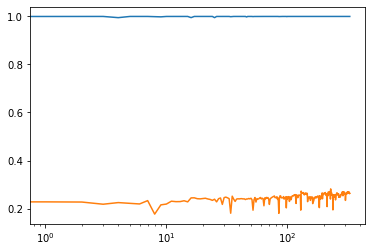

In [22]:
plt.semilogx(history.history['accuracy'])
plt.semilogx(history.history['val_accuracy'])

In [23]:
submodel = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
    )
z = submodel.predict(X_train)
np.shape(z)

(40000, 256)

In [24]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 11 22:49:14 2020 Finding Nearest Neighbors
Tue Aug 11 22:49:14 2020 Building RP forest with 15 trees
Tue Aug 11 22:49:15 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
Tue Aug 11 22:49:25 2020 Finished Nearest Neighbor Search
Tue Aug 11 22:49:28 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Aug 11 22:49:52 2020 Finished embedding


In [25]:
predictions = model.predict(X_train)

In [26]:
mask = np.array(np.argmax(predictions, axis=1)) != Y_train.flatten()

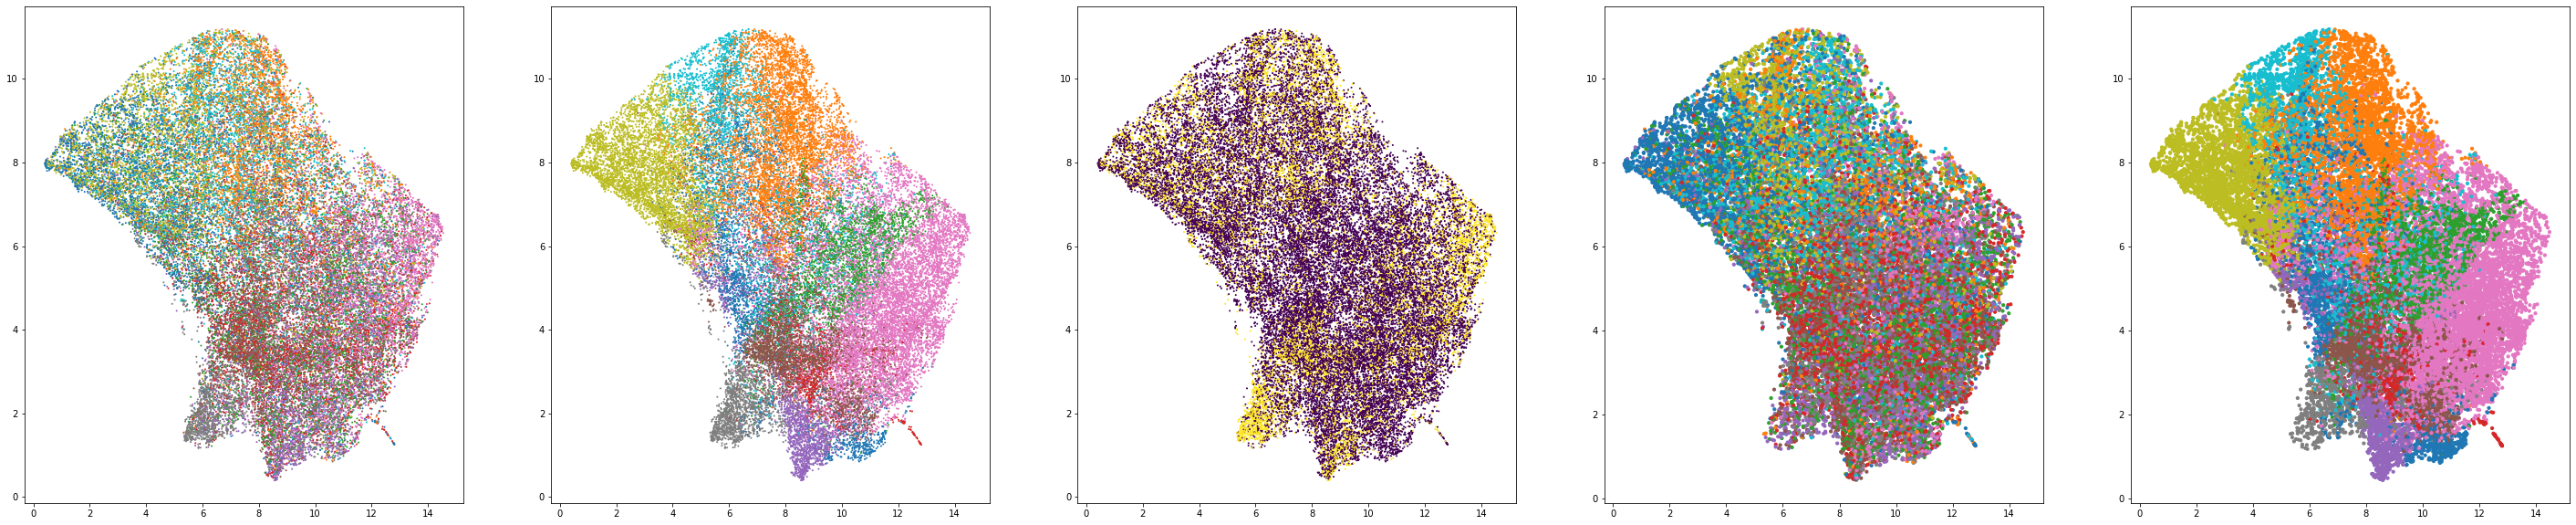

In [27]:
fig, axs = plt.subplots(ncols = 5, figsize=(50,10))
axs[0].scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 1, cmap = plt.cm.tab10)
axs[1].scatter(embedding[:, 0], embedding[:, 1], c=np.argmax(predictions, axis=1), s= 1, alpha = 1, cmap = plt.cm.tab10)
axs[2].scatter(embedding[:, 0], embedding[:, 1], c=np.array(np.argmax(predictions, axis=1)) == Y_train.flatten(), s= 1, alpha = 1, cmap = plt.cm.viridis)
axs[3].scatter(embedding[mask, 0], embedding[mask, 1], c=Y_train.flatten()[mask], s= 10, alpha = 1, cmap = plt.cm.tab10)
axs[4].scatter(embedding[mask, 0], embedding[mask, 1], c=np.argmax(predictions, axis=1)[mask], s= 10, alpha = 1, cmap = plt.cm.tab10)

### save results

In [28]:
# save score, valid embedding, weights, results

In [29]:
from tfumap.paths import MODEL_DIR, ensure_dir

In [30]:
save_folder = MODEL_DIR / 'semisupervised-keras' / dataset / str(labels_per_class) / datestring
ensure_dir(save_folder)

#### save weights

In [31]:
encoder = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
)

In [32]:
encoder.save_weights((save_folder / "encoder").as_posix())

In [33]:
classifier = tf.keras.models.Model(
        [tf.keras.Input(tensor=model.get_layer('weight_normalization').input)], [model.outputs[0]]
)
print([i.name for i in classifier.layers])

['input_2', 'weight_normalization', 'lrelufc1', 'weight_normalization_1', 'lrelufc2', 'weight_normalization_2']


In [34]:
classifier.save_weights((save_folder / "classifier").as_posix())

In [35]:
model.save_weights((save_folder / "full_model").as_posix())

#### save score

In [36]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

313/313 [==============================] - 3s 9ms/step - loss: 2.4894 - accuracy: 0.2814


In [37]:
np.save(save_folder / 'test_loss.npy', result)

#### save embedding

In [38]:
z = encoder.predict(X_train)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Tue Aug 11 22:50:19 2020 Finding Nearest Neighbors
Tue Aug 11 22:50:19 2020 Building RP forest with 15 trees
Tue Aug 11 22:50:19 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
Tue Aug 11 22:50:21 2020 Finished Nearest Neighbor Search
Tue Aug 11 22:50:21 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Aug 11 22:50:45 2020 Finished embedding


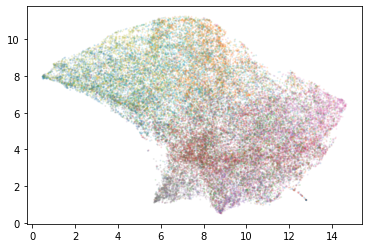

In [39]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [40]:
np.save(save_folder / 'train_embedding.npy', embedding)

#### save results

In [41]:
import pickle

In [42]:
with open(save_folder / 'history.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)